In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [3]:
stk = pd.read_csv('AAPL.CSV')

# Change date column to datetime type
stk['Date'] = stk['Date'].str.split(' ').str[0]
stk['date'] = pd.to_datetime(stk['Date'])

# Save target series
series = stk['Close']

# Create train data set
train_split_date = '2014-12-31'
train_split_index = np.where(stk.Date == train_split_date)[0][0]
x_train = stk.loc[stk['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(stk.Date == test_split_date)[0][0]
x_test = stk.loc[stk['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = stk.loc[(stk['Date'] < test_split_date) & (stk['Date'] > train_split_date)]['Close']

8588 8589 9594 9595 10913


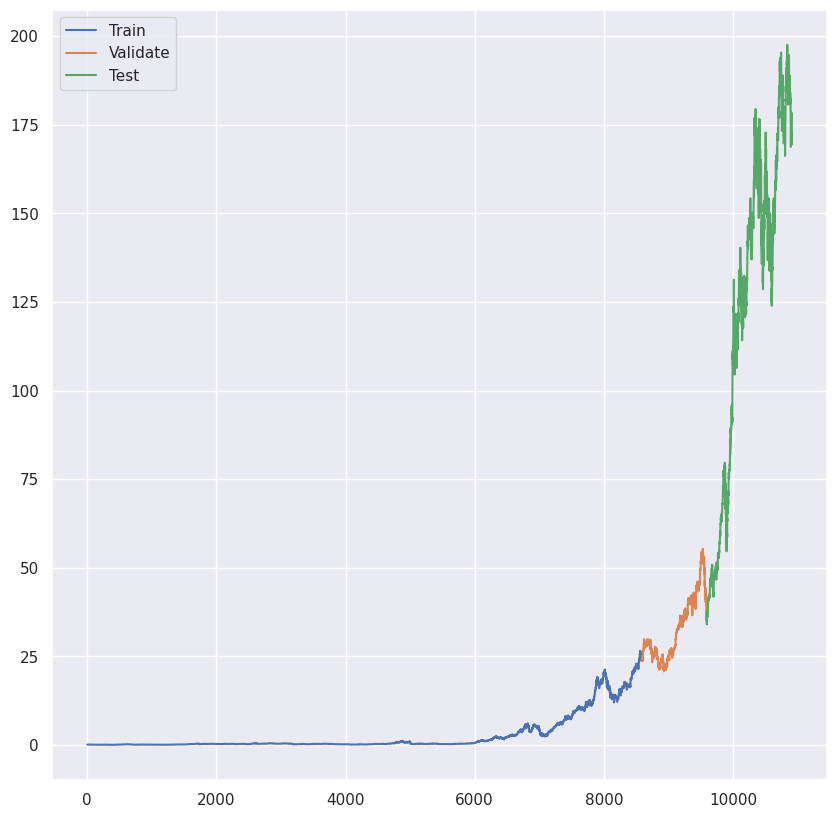

In [4]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [5]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))


In [6]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [7]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
429/429 [==============================] - 9s 7ms/step - loss: 2.3748e-04 - mae: 0.0121 - lr: 1.0000e-05
Epoch 2/100
429/429 [==============================] - 3s 7ms/step - loss: 3.9926e-04 - mae: 0.0183 - lr: 1.1220e-05
Epoch 3/100
429/429 [==============================] - 3s 8ms/step - loss: 7.9067e-05 - mae: 0.0058 - lr: 1.2589e-05
Epoch 4/100
429/429 [==============================] - 3s 7ms/step - loss: 7.6776e-05 - mae: 0.0056 - lr: 1.4125e-05
Epoch 5/100
429/429 [==============================] - 3s 7ms/step - loss: 7.4587e-05 - mae: 0.0053 - lr: 1.5849e-05
Epoch 6/100
429/429 [==============================] - 4s 8ms/step - loss: 7.3037e-05 - mae: 0.0050 - lr: 1.7783e-05
Epoch 7/100
429/429 [==============================] - 3s 7ms/step - loss: 7.1871e-05 - mae: 0.0049 - lr: 1.9953e-05
Epoch 8/100
429/429 [==============================] - 3s 7ms/step - loss: 7.0850e-05 - mae: 0.0049 - lr: 2.2387e-05
Epoch 9/100
429/429 [==============================] - 3s 8ms/st

(1e-08, 1.0, 0.0, 0.01)

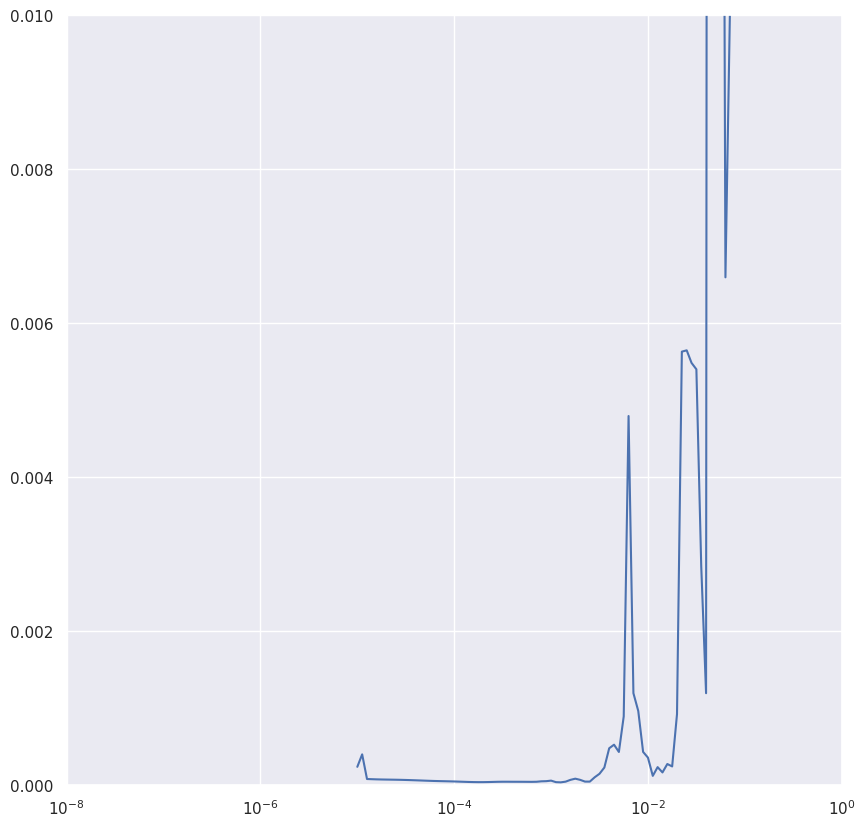

In [8]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1, 0, 0.01])

In [15]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-4)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
286/286 [==============================] - 13s 31ms/step - loss: 2.1993e-04 - mae: 0.0089 - val_loss: 0.0275 - val_mae: 0.1696
Epoch 2/500
286/286 [==============================] - 8s 27ms/step - loss: 8.0128e-04 - mae: 0.0139 - val_loss: 0.0203 - val_mae: 0.1509
Epoch 3/500
286/286 [==============================] - 2s 8ms/step - loss: 8.0530e-04 - mae: 0.0178 - val_loss: 0.0239 - val_mae: 0.1559
Epoch 4/500
286/286 [==============================] - 9s 31ms/step - loss: 7.6174e-04 - mae: 0.0171 - val_loss: 0.0132 - val_mae: 0.1162
Epoch 5/500
286/286 [==============================] - 8s 29ms/step - loss: 4.1449e-04 - mae: 0.0127 - val_loss: 0.0055 - val_mae: 0.0716
Epoch 6/500
286/286 [==============================] - 8s 27ms/step - loss: 1.5381e-04 - mae: 0.0074 - val_loss: 0.0032 - val_mae: 0.0542
Epoch 7/500
286/286 [==============================] - 3s 10ms/step - loss: 3.6851e-05 - mae: 0.0039 - val_loss: 0.0039 - val_mae: 0.0580
Epoch 8/500
286/286 [=============

In [16]:
# recall best model
model = keras.models.load_model("my_checkpoint")

In [17]:
# make predictions
forecast = model.predict(normalized_x_test[np.newaxis,:])
forecast = forecast.flatten()

1/1 [==============================] - 1s 604ms/step


In [18]:
# Example of how to iverse
unscaled_forecast = x_train_scaler.inverse_transform(forecast.reshape(-1,1)).flatten()
unscaled_forecast.shape

(1319,)

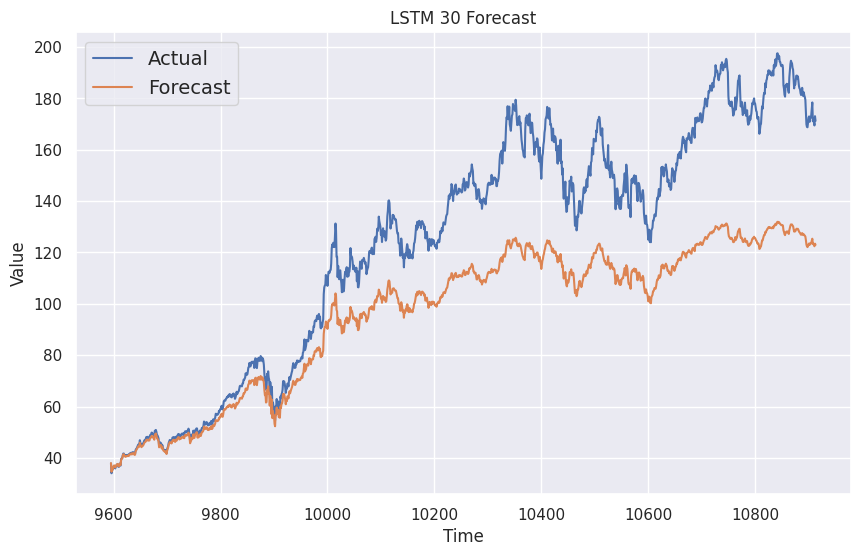

In [19]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, unscaled_forecast, label="Forecast")
plt.show()

In [20]:
# calculate MAE
keras.metrics.mean_absolute_error(x_test, unscaled_forecast).numpy()

27.74849